In [26]:
import pandas as pd
from sklearn.preprocessing import *
import matplotlib.pyplot as plt
import numpy as np
import SSVAERegressor
import util
import tensorflow as tf

# Data loading

In [2]:
# Microarray Data
X_df = pd.read_table("Drug_data/entire_data_only_AML_and_UW_joined.tsv", index_col=0)
print(X_df.shape)
print(X_df.index)
print(X_df.columns)
xp = X_df.values
print(xp.shape)

# Drug Sensitivity data
Y_df = pd.read_table("Drug_data/UW_AML.patient_batch123.AUC.renamed.txt", index_col=0, low_memory=False)
Y_df = Y_df.iloc[:, 1:-1]
Y_df = Y_df.transpose()
print(Y_df.shape)
print(Y_df.index)
print(Y_df.columns)
drug = Y_df.values
print(drug.shape)

(3439, 4051)
Index([u'GSM158711', u'GSM158712', u'GSM158713', u'GSM158714', u'GSM158715',
       u'GSM158716', u'GSM158717', u'GSM158718', u'GSM158719', u'GSM158720',
       ...
       u'AML052', u'AML055', u'AML062Ph', u'AML071', u'AML010', u'AML013',
       u'AML051', u'AML079', u'AML098', u'AML099'],
      dtype='object', length=3439)
Index([u'GUCA1A', u'PTPN21', u'SCARB1', u'MAPK1', u'EYA3', u'RBBP6', u'TRIOBP',
       u'CNOT7', u'CRYZL1', u'ETV3',
       ...
       u'HNRNPUL2', u'TNS4', u'TMEM209', u'KCNC2', u'SCAF4', u'ZNF324B',
       u'ALS2CL', u'LAMA1', u'FBXO31', u'SLC44A1'],
      dtype='object', length=4051)
(3439, 4051)
(30, 159)
Index([u'AML.017', u'AML.030', u'AML.044', u'AML.056', u'AML.059', u'AML.060',
       u'AML.061', u'AML.067', u'AML.068', u'AML.069', u'AML.070', u'AML.076',
       u'AML.063', u'AML.074', u'AML.077', u'AML.078', u'AML.083', u'AML.086',
       u'AML012', u'AML039', u'AML052', u'AML055', u'AML062', u'AML071',
       u'AML010', u'AML013', u'AML051',

In [49]:
drug_index = 2
train_unlabeled = util.BatchFeeder(xp[:-30], np.zeros((3409, 159)), 40)
train_labeled = util.BatchFeeder(xp[-30:-10], scale(drug[:-10, drug_index].reshape((20,1))), 20)
test_labeled = (xp[-10:], scale(drug[-10:, drug_index].reshape((10,1))))

# Train on drug data

In [ ]:
model = SSVAERegressor.SSVAERegressor(input_dim=4051,
                                      vae_dims=[128],
                                      reg_dims=[128],
                                      latent_dim=32,
                                      prediction_dim=1)

In [ ]:
model.train(train_labeled, train_unlabeled, 4000, test_labeled)

Epoch: [2666/4000] loss: 4316.93, kld: 74.92, rec: 4240.27, logdensity(labeled): 0.82, kld(unlabeled): 1.83, mse: 0.70302

# Compare to MLP

In [40]:
# Adapted from M2

class MLP():
    def __init__(self, input_dim, reg_dims, prediction_dim, verbose=False):
        # Reset all existing tensors
        tf.reset_default_graph()
        
        # Tracking data
        self.loss = {}
        self.record = {}
        
        # Define some parameters
        self.e = 0
        self.verbose = verbose
        
        # Define dimensionality
        self.input_dim = input_dim
        self.dims = reg_dims
        self.prediction_dim = prediction_dim
        
        # Building the graph
        self.built = False
        self.sesh = tf.Session()
        self.ops = self.build()
        self.sesh.run(tf.global_variables_initializer())
        writer = tf.summary.FileWriter('logs', self.sesh.graph)
        
    def build(self):
        # Placeholders for input and dropout probs.
        if self.built:
            return -1
        else:
            self.built = True
            
        #####################
        # Building networks #
        #####################
        
        # Defining inputs
        x_in_labeled = tf.placeholder(tf.float32, shape=[None, self.input_dim], name="x_in_labeled")
        y = tf.placeholder(tf.float32, shape=[None, self.prediction_dim], name="y")
        
        # Building network q(y|x)
        pred = self.encoder(x_in_labeled,
                            output_dim=self.prediction_dim,
                            _is_train=True,
                            scope="regressor")
        
        
        #################
        # Defining loss #
        #################
        
        # Defining Loss for labeled data
        with tf.variable_scope("loss"):
            loss = tf.reduce_mean(tf.square(y-pred))
        
        ################
        # Optimization #
        ################
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            optim = tf.train.AdamOptimizer().minimize(loss)
            
        #########################
        # Network for later use #
        #########################
        x_ = tf.placeholder(tf.float32, shape=[None, self.input_dim], name="x")
        # Building network q(y|x)
        pred_= self.encoder(x_, output_dim=self.prediction_dim, _is_train=False, scope="regressor", reuse=True)
            
        return dict(
            x_in_labeled = x_in_labeled,
            y = y,
            x_ = x_,
            pred_ = pred_,
            optim = optim,
            loss = loss
        )
        
    ###########
    # Encoder #
    ###########
    def encoder(self, _input, _is_train, output_dim, _fn=tf.nn.relu, scope="encoder", reuse=None):
        with tf.variable_scope(scope, reuse=reuse):
            net = _input
            for dim in self.dims:
                net = tf.contrib.slim.fully_connected(net, dim, activation_fn=tf.identity)
                if self.verbose: print net
                net = tf.contrib.layers.batch_norm(net, is_training=_is_train)
                net = _fn(net)
            
            mu = tf.contrib.slim.fully_connected(net, output_dim, activation_fn=tf.identity)
            if self.verbose: print mu
            return mu
   
    ############
    # Training #
    ############
    def train(self, X_labeled, epochs, valid=None):
        e = 0
        start_e = self.e
        while e < epochs:
            for i in range(X_labeled.batch_num):
                
                # Get data
                x_labeled, y = X_labeled.next()
                
                # Training with labeled data
                feed_dict = {self.ops["x_in_labeled"]: x_labeled,
                             self.ops["y"]: y}
                ops_to_run = [self.ops["loss"],
                              self.ops["optim"]]
                loss, _ = self.sesh.run(ops_to_run, feed_dict)
                
                # Use Validation
                if valid != None:
                    pred = self.predict(valid[0])
                    mse = np.mean(np.square(valid[1]-pred[:, 0]))
                    
                
                if valid!=None:
                    sys.stdout.write("\rEpoch: [%2d/%2d] loss: %.2f, mse: %.2f"
                                     %(self.e, start_e+epochs, loss, mse))
                else:
                    sys.stdout.write("\rEpoch: [%2d/%2d] loss: %.2f"
                                     %(self.e, start_e+epochs, loss))

            self.e+=1
            e+= 1
            
    ##############
    # Prediction #
    ##############
    def predict(self, x=None):
        return self.sesh.run(self.ops["pred_"], {self.ops["x_"]: x})

In [42]:
model2 = MLP(input_dim=4051,
             reg_dims=[64],
             prediction_dim=1)

Epoch: [7999/8000] loss: 4418.01, kld: 62.17, rec: 4353.79, logdensity(labeled): 2.48, kld(unlabeled): 2.29, mse: 0.522

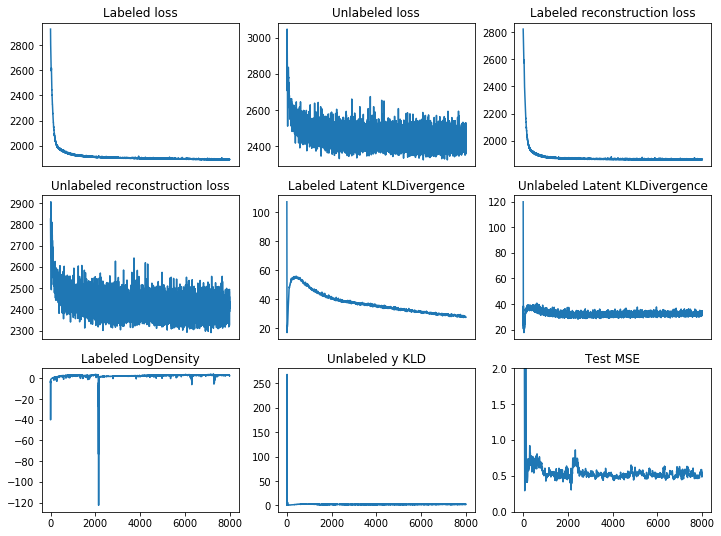

In [43]:
model.train(train_labeled, train_unlabeled, 4000, test_labeled)